# COVID-19 Policy Analysis

## Import required modules

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pandas.plotting import register_matplotlib_converters
from celluloid import Camera
from IPython.display import HTML
from adjustText import adjust_text
from numpy.polynomial.polynomial import polyfit

register_matplotlib_converters()
pd.options.mode.chained_assignment = None # default='warn'

## Load data

In [2]:
# Read in the data
epi_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", 
                       keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

gr_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
                      keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

demo_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv", 
                       keep_default_na=False, na_values=[""])

xls = pd.ExcelFile("https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx")
fc_data = pd.read_excel(xls, 'h6_facial_coverings')

## List of country and state codes

In [24]:
# second code required for face covering policy data

country_code = [
['US','USA'],
['IL','ISR'],
['AT','AUT'],
['BE','BEL'],
['CZ','CZE'],
['DK','DNK'],
['FI','FIN'],
['FR','FRA'],
['GB','GBR'],
['DE','DEU'],
['IE','IRL'],
['IT','ITA'],
['NL','NLD'],
['PT','PRT'],
['ES','ESP'],
['SE','SWE'],
['NO','NOR'],
['CH','CHE'],
['IS','ISL'],
['TR','TUR'],
['SK','SVK'],
['HU','HUN'],
['BG','BGR']]

state_code = [
['US_AK','USA'],
['US_AL','USA'],
['US_AR','USA'],
['US_AZ','USA'],
['US_CA','USA'],
['US_CO','USA'],
['US_CT','USA'],
['US_DC','USA'],
['US_DE','USA'],
['US_FL','USA'],
['US_GA','USA'],
['US_HI','USA'],
['US_IA','USA'],
['US_ID','USA'],
['US_IL','USA'],
['US_IN','USA'],
['US_KS','USA'],
['US_KY','USA'],
['US_LA','USA'],
['US_MA','USA'],
['US_MD','USA'],
['US_ME','USA'],
['US_MI','USA'],
['US_MN','USA'],
['US_MO','USA'],
['US_MS','USA'],
['US_MT','USA'],
['US_NC','USA'],
['US_ND','USA'],
['US_NE','USA'],
['US_NH','USA'],
['US_NJ','USA'],
['US_NM','USA'],
['US_NV','USA'],
['US_NY','USA'],
['US_OH','USA'],
['US_OK','USA'],
['US_OR','USA'],
['US_PA','USA'],
['US_RI','USA'],
['US_SC','USA'],
['US_SD','USA'],
['US_TN','USA'],
['US_TX','USA'],
['US_UT','USA'],
['US_VA','USA'],
['US_VT','USA'],
['US_WA','USA'],
['US_WI','USA'],
['US_WV','USA'],
['US_WY','USA']]

## Process data for regions listed above

In [4]:
start_remove = ('2019-12-30')
end_remove = ('2019-12-31')
epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]

def preprocess_fc_data(data):
    data.columns = ['face_covering']
    data.index.name = 'date'
    data.index = pd.to_datetime(data.index)
    return data

def preprocess_data(epi_data, gr_data, fc_data, demo_data, code1, code2):
    epi_df = epi_data[(epi_data.key) == code1]
    epi_df['rolling_cases'] = epi_df['new_confirmed'].rolling(7).mean()
    gr_df = gr_data[(gr_data.key) == code1]
    fc_df = fc_data[(fc_data.country_code) == code2].drop(columns=['country_code', 'country_name']).T
    try:
        fc_df = preprocess_fc_data(fc_df)
    except:
        print(code1)
    demo_df = demo_data[(demo_data.key == code1)]
    return epi_df, gr_df, fc_df, demo_df
    
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    cc2 = state_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)
    
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    cc2 = country_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)

# epidemiology data consists of the following columns
# date, key, new_confirmed, new_deceased, new_recovered, new_tested, total_confirmed, total_deceased,
# total_recovered, total_tested

# government response data consists of many columns. Can see them here
# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies

## Plotting functions

In [6]:
def calculate_average_stringency_index(epi_data, gr_data, demo_data, country):
    gr_data['si_average'] = gr_data['stringency_index'].sum()/len(gr_data)
    return pd.to_numeric(gr_data['si_average'].values[0])   

def calculate_average_containment_index(epi_data, gr_data, demo_data, country):
    C1 = gr_data['school_closing']/3
    C2 = gr_data['workplace_closing']/3
    C3 = gr_data['cancel_public_events']/2
    C4 = gr_data['restrictions_on_gatherings']/4
    C5 = gr_data['public_transport_closing']/2
    C6 = gr_data['stay_at_home_requirements']/3
    C7 = gr_data['restrictions_on_internal_movement']/2
    C8 = gr_data['international_travel_controls']/4
    gr_data['contain_policy_avg'] = ((C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8) / 8 ) * 100
    gr_data['containment_idx'] = gr_data['contain_policy_avg'].sum()/len(gr_data)
    return pd.to_numeric(gr_data['containment_idx'].values[0]) 

def calculate_average_health_index(epi_data, gr_data, demo_data, fc_data, country):
    H1 = gr_data['public_information_campaigns']/2
    H2 = gr_data['testing_policy']/3
    H3 = gr_data['contact_tracing']/2
#     H4 = gr_data['emergency_investment_in_healthcare']
#     H5 = gr_data['investment_in_vaccines']
    H6 = fc_data['face_covering']/4
    gr_data['health_policy_avg'] = ((H1 + H2 + H3 + H6) / 4 ) * 100
    gr_data['health_idx'] = gr_data['health_policy_avg'].sum()/len(gr_data)
    return pd.to_numeric(gr_data['health_idx'].values[0]) 

def plot_state_by_index(epi_data, demo_data, country, ax0, ax, i, state_list, zlim):
    start_remove = ('2019-12-30')
    end_remove = ('2020-2-29')
    epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    p = ax0.fill_between(epi_data.index.values, case_rate_100K)
    path = p.get_paths()[0]
    pp = patches.PathPatch(path, alpha=0.15)
    ax.add_patch(pp)
    art3d.pathpatch_2d_to_3d(pp,z=i,zdir='y')
    ax.set_xlim3d([dt.date(2020, 3, 1), dt.date(2020, 12, 1)])
    ax.set_ylim3d(0, i)
    ax.set_zlim3d(0, zlim)
    ax.grid(False)
    months = {"Jan":0, "Feb":1, "Mar":2, "Apr":3, "May":4, "Jun":5, "Jul":6, 
              "Aug":7, "Sep":8, "Oct":9, "Nov":10, "Dec":11 }
    month_idx = np.unique(epi_data.index.month_name()).tolist()
    month_idx = [month[0:3] for month in month_idx]
    month_idx = sorted(month_idx, key=months.get)
    ax.set_xticklabels(month_idx, fontsize=11)
    ax.yaxis._axinfo['juggled'] = (1,1,0)
    ax.set_yticks(np.arange(1,len(state_list)+1))
    ax.set_yticklabels(state_list, 
                verticalalignment='baseline',
                horizontalalignment='right',
                fontsize=9)
    ax.set_zticks([])
    ax.w_zaxis.line.set_lw(0.)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    return

## US cases per capita by state

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


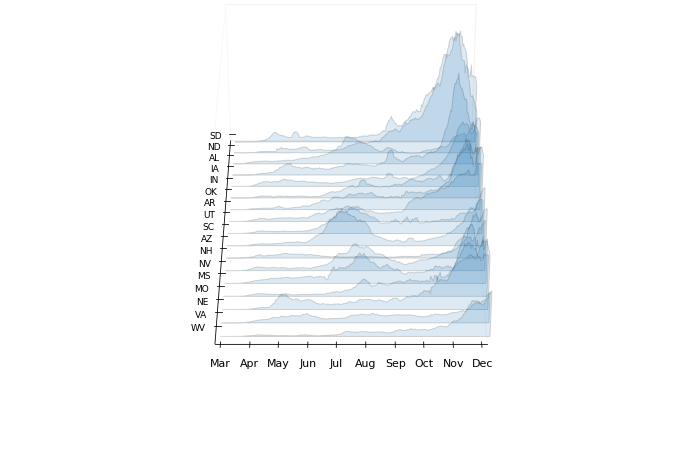

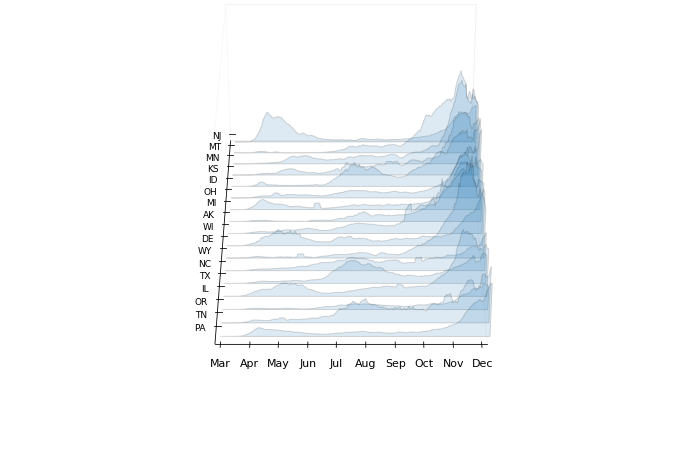

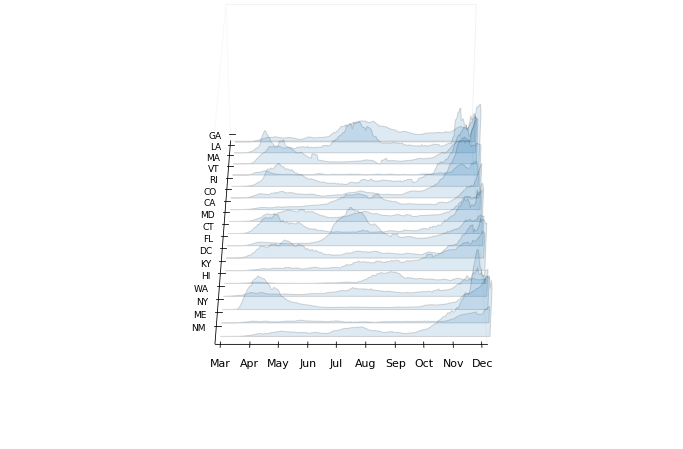

In [31]:
state_ci = []
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    tmp = calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    state_ci.append([cc1, tmp])

state_ci.sort(key = lambda x: x[1], reverse=True)
ci_thresholds = [0, 47, 50, 100]
ci_thresholds = [0, 48.5, 52.7, 100]

for x in range(3):
    fig = plt.figure(figsize=(12, 8))
    ax0 = plt.figure().gca()
    ax = fig.gca(projection='3d')
    ax.elev = 35
    ax.azim = 270
    ax.dist = 14
    x_scale = 1
    y_scale = 2.1
    z_scale = 1
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([x_scale, y_scale, z_scale, 1]))

    j = 0 
    state_list = []
    for i in range(len(state_code)):
        state = state_ci[i][0]
        if state_ci[i][1] < ci_thresholds[x+1] and state_ci[i][1] >= ci_thresholds[x]:
            state_list.append(state[3:])
    for i in range(len(state_code)):
        state = state_ci[i][0]
        if state_ci[i][1] < ci_thresholds[x+1] and state_ci[i][1] >= ci_thresholds[x]:
            plot_state_by_index(globals()["{0}_epi_df".format(state)], globals()["{0}_demo_df".format(state)], 
                                state, ax0, ax, j, state_list, zlim=200)
            j += 1
    plt.close()
    plt.savefig("testing_{0}".format(x), dpi=300)

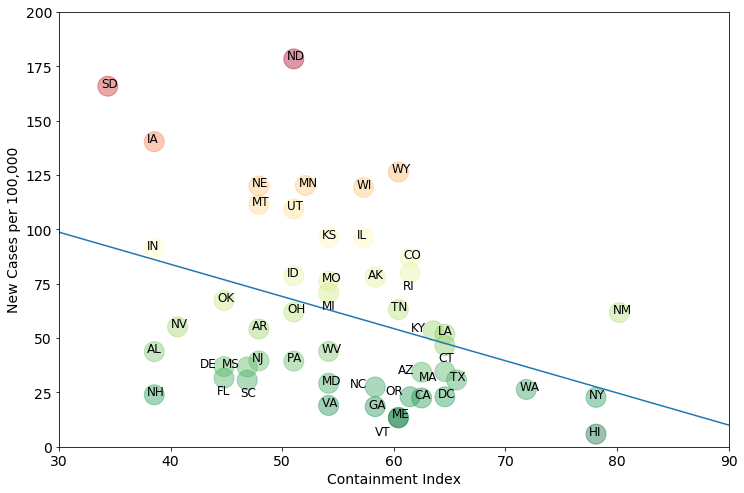

In [11]:
case_rate_v_containment = []
date1 = '2020-11-1'
date2 = '2020-11-16'
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    try:
        date_si = globals()["{0}_gr_df".format(cc1)][pd.Timestamp(date1):pd.Timestamp(date1)]['contain_policy_avg'].values[0]
    except:
        print(cc1)
    try:
        case_rate_100K = globals()["{0}_epi_df".format(cc1)]['rolling_cases']/globals()["{0}_demo_df".format(cc1)]['population'].values[0]*100000
    except:
        print(cc1)
    date_cr = case_rate_100K[pd.Timestamp(date2):pd.Timestamp(date2)].values[0]
    case_rate_v_containment.append([cc1, date_si, date_cr])

case_rate_v_containment.sort(key = lambda x: x[1], reverse=True)
case_rate_v_containment = np.array(case_rate_v_containment)
plt.figure(figsize=(12,8))
label = case_rate_v_containment[:,0]
label = [state[3:] for state in label]
x = case_rate_v_containment[:,1].astype(float)
y = case_rate_v_containment[:,2].astype(float)
plt.scatter(x, y, s=400, c=y, cmap='RdYlGn_r', alpha=0.4)
plt.xlim((30, 90))
plt.ylim((0, 200))
plt.xlabel('Containment Index', fontsize=14)
plt.ylabel('New Cases per 100,000', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
line_x = range(0,101)
b, m = polyfit(x, y, 1)
plt.plot(line_x, b + m * line_x, '-', linewidth=1.5)
texts = []
for i, txt in enumerate(label):
    texts.append(plt.text(x[i]-0.65, y[i]-2.25, txt, fontsize=12))
adjust_text(texts)
# plt.savefig('US_scatter', dpi=300)
plt.show()

In [25]:
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    tmp = calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    
region_code = country_code
fig = plt.figure(figsize=(12, 8))
camera = Camera(fig)
path = []
for j in range(250,350): # 70, 250
    skip = False
    case_rate_v_containment = []
    for i in range(len(region_code)):
        cc1 = region_code[i][0]
        try:
            date_si = globals()["{0}_gr_df".format(cc1)]['contain_policy_avg'].values[j]
            if np.isnan(date_si) == True:
                skip = True
        except:
            skip = True
        try:
            case_rate_100K = globals()["{0}_epi_df".format(cc1)]['rolling_cases']/globals()["{0}_demo_df".format(cc1)]['population'].values[0]*100000
        except:
            skip = True
        try:
            date_cr = case_rate_100K.values[j]
        except:
            skip = True
        if skip == True:
            break
        case_rate_v_containment.append([cc1, date_si, date_cr])
    if skip == True:
        continue
    case_rate_v_containment.sort(key = lambda x: x[1], reverse=True)
    case_rate_v_containment = np.array(case_rate_v_containment)
    label = case_rate_v_containment[:,0]
    x = case_rate_v_containment[:,1].astype(float)
    y = case_rate_v_containment[:,2].astype(float)
    norm = plt.Normalize(vmin=0, vmax=90)
    plt.scatter(x, y, s=300, c=y, norm=norm, cmap='RdYlGn_r', alpha=0.4)
    plt.xlim((0, 100))
    plt.ylim((0, 175)) # 200, 175
    plt.xlabel('Containment Index', fontsize=14)
    plt.ylabel('New Cases per 100,000', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    text = globals()["{0}_gr_df".format(cc1)].index[j].strftime("%d-%b-%Y")
    plt.text(50, 165, text, horizontalalignment='center', verticalalignment='center', fontsize=18)
    for i, txt in enumerate(label):
        plt.annotate(txt, (x[i]-1, y[i]-2), fontsize=12)
    camera.snap()
anim = camera.animate()
plt.close()
HTML(anim.to_html5_video())

## Case count vs stringency index

In [13]:
def plot_containment_index(epi_data, gr_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    months = {"Jan":0, "Feb":1, "Mar":2, "Apr":3, "May":4, "Jun":5, "Jul":6, 
              "Aug":7, "Sep":8, "Oct":9, "Nov":10, "Dec":11 }
    month_idx = np.unique(epi_data.index.month_name()).tolist()
    month_idx = [month[0:3] for month in month_idx]
    month_idx = sorted(month_idx, key=months.get)
    gs = gridspec.GridSpec(9,1, height_ratios=[4,1,1,1,1,1,1,1,1])
    fig = plt.figure(figsize=(15, 7))

    ax = fig.add_subplot(gs[0]) 
    ax.set(ylabel='Containment Index')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.fill_between(gr_data.index.values,
                     gr_data['contain_policy_avg'],
                     label='containment index',
                     color='red',
                     alpha=0.25)
    ax.set_ylim([0,100])
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)

    ax2 = ax.twinx()
    ax2.bar(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100,000',
            alpha=0.5)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax2.set(ylabel='New Cases per 100,000',
           title=country + ' Containment Policies')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_ylim([0, case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    x_axis = ax2.axes.get_xaxis()
    x_axis.set_visible(False)
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    leg = plt.legend(handles,labels, loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax3 = fig.add_subplot(gs[1], sharex=ax)
    ax3.fill_between(gr_data.index.values, 
                     gr_data['school_closing']/3,
                     label='school closures',
                     color='green',
                     alpha=0.25)
    ax3.set_ylim([0,1])
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.set_yticks([])
    x_axis = ax3.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax4 = fig.add_subplot(gs[2], sharex=ax)
    ax4.fill_between(gr_data.index.values,
                     gr_data['workplace_closing']/3,
                     label='workplace closures',
                     color='darkorange',
                     alpha=0.25)
    ax4.set_ylim([0,1])
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.set_yticks([])
    x_axis = ax4.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax5 = fig.add_subplot(gs[3], sharex=ax)
    ax5.fill_between(gr_data.index.values,
                     gr_data['cancel_public_events']/2,
                     label='public event cancellations',
                     color='magenta',
                     alpha=0.25)
    ax5.set_ylim([0,1])
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.set_yticks([])
    x_axis = ax5.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax6 = fig.add_subplot(gs[4], sharex=ax)
    ax6.fill_between(gr_data.index.values,
                     gr_data['restrictions_on_gatherings']/4,
                     label='gathering restrictions',
                     color='gold',
                     alpha=0.25)
    ax6.set_ylim([0,1])
    ax6.spines['right'].set_visible(False)
    ax6.spines['top'].set_visible(False)
    ax6.spines['left'].set_visible(False)
    ax6.set_yticks([])
    x_axis = ax6.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax7 = fig.add_subplot(gs[5], sharex=ax)
    ax7.fill_between(gr_data.index.values,
                     gr_data['public_transport_closing']/2,
                     label='public transport closures',
                     color='blue',
                     alpha=0.25)
    ax7.set_ylim([0,1])
    ax7.spines['right'].set_visible(False)
    ax7.spines['top'].set_visible(False)
    ax7.spines['left'].set_visible(False)
    ax7.set_yticks([])
    x_axis = ax7.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax8 = fig.add_subplot(gs[6], sharex=ax)
    ax8.fill_between(gr_data.index.values,
                     gr_data['stay_at_home_requirements']/3,
                     label='stay at home requirements',
                     color='darkred',
                     alpha=0.25)
    ax8.set_ylim([0,1])
    ax8.spines['right'].set_visible(False)
    ax8.spines['top'].set_visible(False)
    ax8.spines['left'].set_visible(False)
    ax8.set_yticks([])
    x_axis = ax8.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax9 = fig.add_subplot(gs[7], sharex=ax)
    ax9.fill_between(gr_data.index.values,
                     gr_data['restrictions_on_internal_movement']/2,
                     label='internal border controls',
                     color='deepskyblue',
                     alpha=0.25)
    ax9.set_ylim([0,1])
    ax9.spines['right'].set_visible(False)
    ax9.spines['top'].set_visible(False)
    ax9.spines['left'].set_visible(False)
    ax9.set_yticks([])
    x_axis = ax9.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax10 = fig.add_subplot(gs[8], sharex=ax)
    ax10.fill_between(gr_data.index.values,
                     gr_data['international_travel_controls']/4,
                     label='international border controls',
                     color='indigo',
                     alpha=0.25)
    ax10.set_ylim([0,1])
    ax10.spines['right'].set_visible(False)
    ax10.spines['top'].set_visible(False)
    ax10.spines['left'].set_visible(False)
    ax10.set_yticks([])
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)  
    ax10.set_xticklabels(month_idx, fontsize=10)
    
    ax10.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    fig.tight_layout()
    plt.show()
    

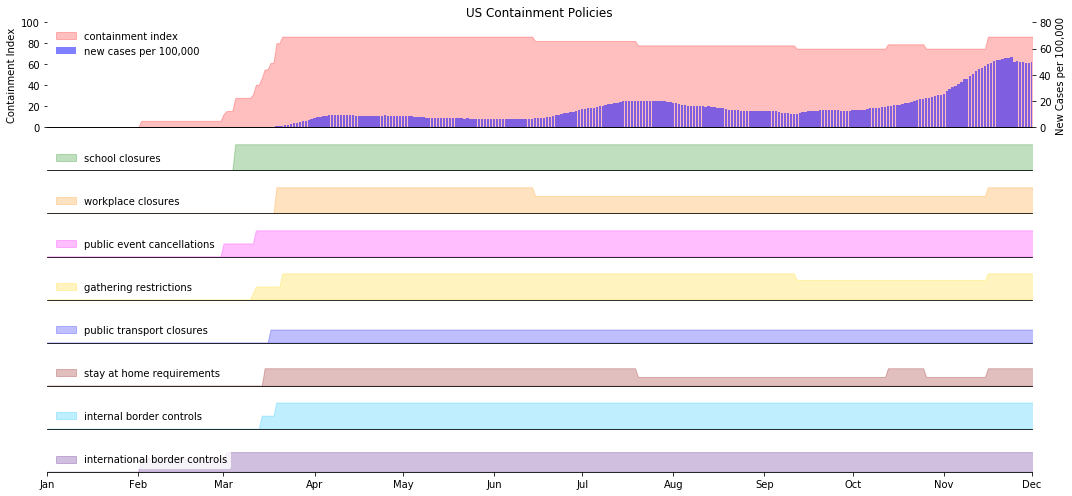

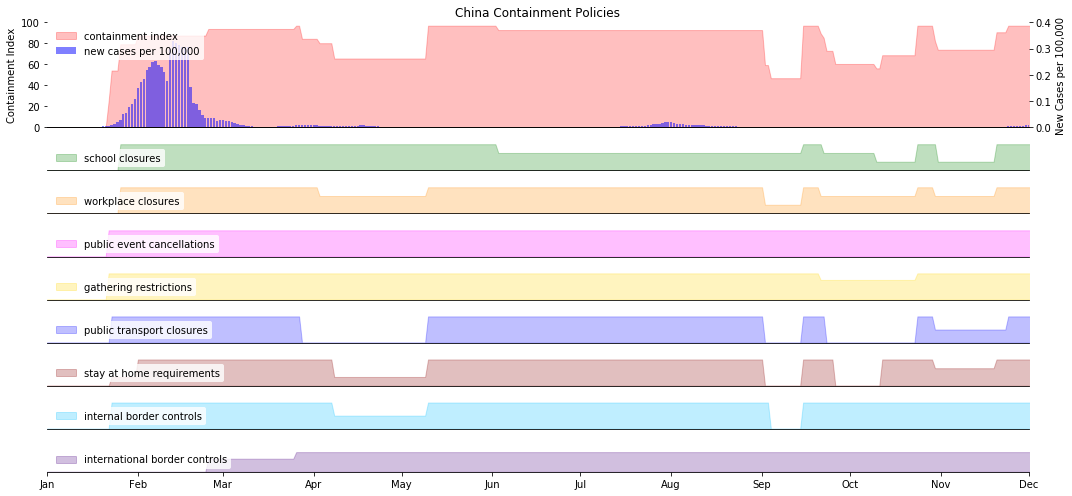

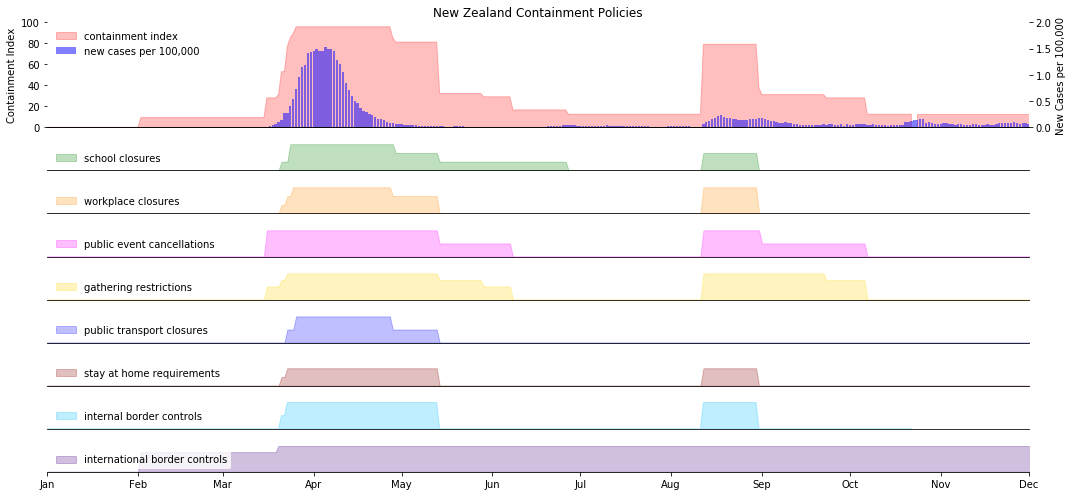

In [15]:
country_code = [
['US','USA'],
['NZ','NZL'],
['CN','CHN']]

for i in range(len(country_code)):
    cc1 = country_code[i][0]
    cc2 = country_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)
    calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    
plot_containment_index(US_epi_df, US_gr_df, US_demo_df, 'US')
plot_containment_index(CN_epi_df, CN_gr_df, CN_demo_df, 'China')
plot_containment_index(NZ_epi_df, NZ_gr_df, NZ_demo_df, 'New Zealand')